In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn import set_config

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [5]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

sns.set_palette('Set2')
set_config(display='diagram')

In [6]:
customer_df = pd.read_csv('data/Mall_Customers.csv')

customer_df = customer_df.drop('CustomerID', axis=1)
customer_df = customer_df.rename(index=str, columns={
    'Annual Income (k$)': 'Income',
    'Spending Score (1-100)': 'SpendingScore'
})

# Mall Customer Segmentation

Perform EDA and find the hidden customer spending patterns in the dataset.

# Dataset Overview

In [7]:
print('Shape: ', customer_df.shape)

print('---')
print(customer_df.dtypes)

print('---')
print(customer_df.describe())

print('---')
print(customer_df.isnull().sum())

Shape:  (200, 4)
---
Gender           object
Age               int64
Income            int64
SpendingScore     int64
dtype: object
---
              Age      Income  SpendingScore
count  200.000000  200.000000     200.000000
mean    38.850000   60.560000      50.200000
std     13.969007   26.264721      25.823522
min     18.000000   15.000000       1.000000
25%     28.750000   41.500000      34.750000
50%     36.000000   61.500000      50.000000
75%     49.000000   78.000000      73.000000
max     70.000000  137.000000      99.000000
---
Gender           0
Age              0
Income           0
SpendingScore    0
dtype: int64


In [8]:
customer_df.head()

,Gender,Age,Income,SpendingScore
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


# EDA

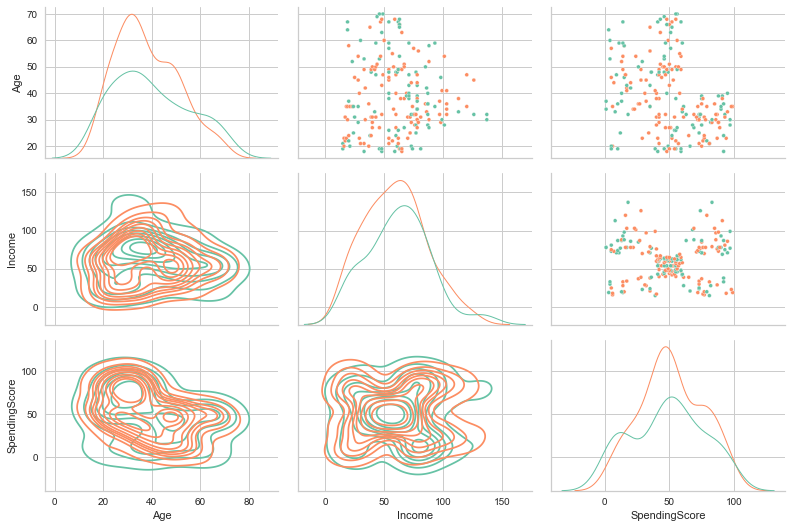

In [9]:
grid = sns.PairGrid(customer_df, hue='Gender', diag_sharey=False, aspect=1.5)

grid.map_upper(sns.scatterplot, s=15)
grid.map_lower(sns.kdeplot)
grid.map_diag(sns.kdeplot, lw=1);

Insights:
- **Age**, **Income** and **Spending Score** features are **multimodal distributions** each having two or three heels
- **Annual Income** and **Spending Score** plot seems to be formed with a **five dense regions**: 4 regions are on the sides and one is in the center

## Customer Profile

### Gender

In [10]:
fig = px.pie(
    data_frame=customer_df, 
    names='Gender', 
    title='Customer Genders', 
    hole=0.1, 
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig.show()

Insights:
- **female customers** are on 6% more then males. Virtually even distribution

In [11]:
customer_df[['Age', 'Income']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
Income,200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0


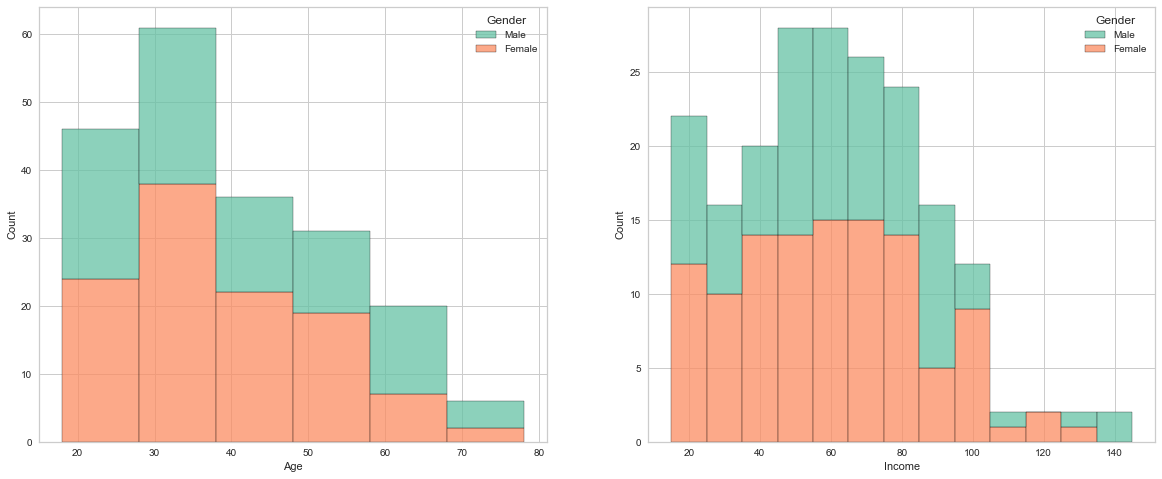

In [12]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 8))

sns.histplot(data=customer_df, x='Age', hue='Gender', binwidth=10, multiple='stack', ax=ax0)
sns.histplot(data=customer_df, x='Income', hue='Gender', binwidth=10, multiple='stack', ax=ax1);

Insights:
- **20-30, 30-40** are **the most common ages groups** among customers
- **The biggest cusomer age group** is **30 year-old** customers (mostly women)
- **Most of customers** earn between **\$50k and \$80k** annually
- **Big part of customers** earn only **$20k** annually

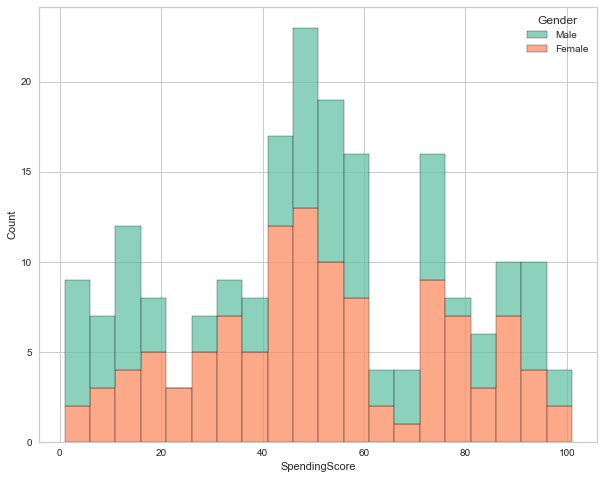

In [13]:
plt.figure(figsize=(10, 8))

sns.histplot(data=customer_df, x='SpendingScore', hue='Gender', binwidth=5, multiple='stack');

Insights:
- Spending scores have a few modes: 
    - between 0 and 20 (men domintate)
    - between 25 and 40 (women domintate)
    - between 45 and 60 (women domintate)
    - between 65 and 70 (men dominates)
    - between 70 and 100 (women dominates) 

## Spending Score

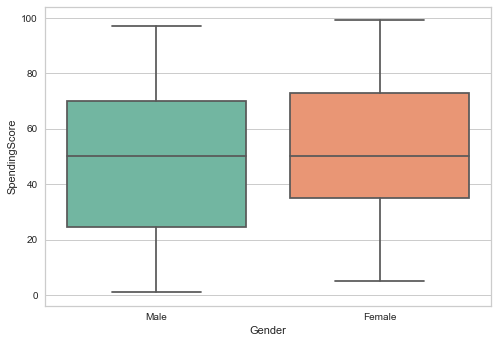

In [14]:
sns.boxplot(data=customer_df, x='Gender', y='SpendingScore');

Insights:
- **Women** tend to **spend more** as we see from the bottom bar bound
- **On average**, **women** just **spend slightly more** then men

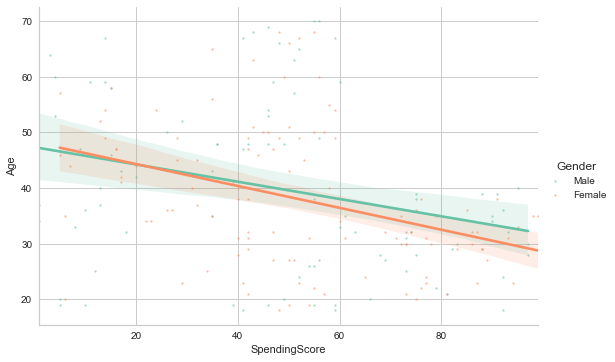

In [15]:
sns.lmplot(
    data=customer_df,
    x='SpendingScore', 
    y='Age', 
    hue='Gender',
    aspect=1.5,
    scatter_kws={'s': 5, 'alpha': 0.6}
);

Insights:
- There is a linear dependency between **Spending Score** and **Age**. Younger customers tend to have higher spending score and spending score decreases when age goes up.

Introducting **Spending Groups** can help to reveal more insights. So let's introduce three spending groups:

In [16]:
def impute_spending_group(spending_score):
    if spending_score <= 35:
        return 'low'
    if spending_score > 35 and spending_score <= 65:
        return 'medium'
    if spending_score > 65:
        return 'high'

customer_df['SpendingGroup'] = customer_df['SpendingScore'].apply(impute_spending_group)

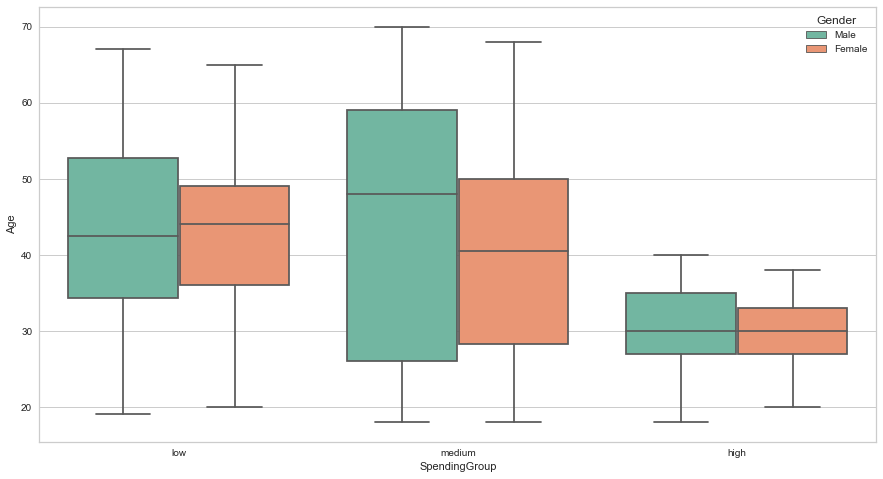

In [17]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=customer_df, x='SpendingGroup', y='Age', hue='Gender', order=['low', 'medium', 'high']);

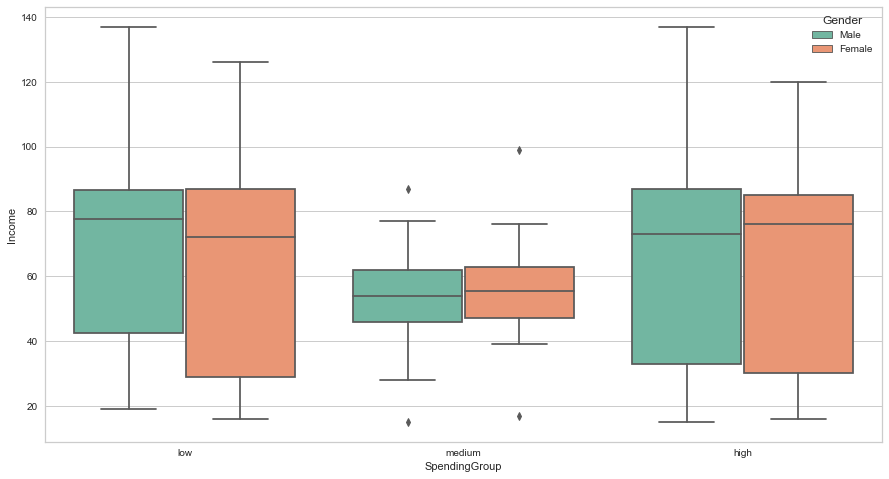

In [18]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=customer_df, x='SpendingGroup', y='Income', hue='Gender', order=['low', 'medium', 'high']);

Insights:
- From the Spending Group - Age plot we can see that the lowest variation is in **high spending group**. Its members are in **20-40 age group**. Low and medium spending groups seem to roughly covers the whole age range.
- From the Spending Group - Annual Income plot we can see that customers from **the center of the annual income distribution** (\$40k-\$60k) belongs to **medium spending group** 

Let's give a deeper look at the **Annual Income** and **Spending Score** relations:

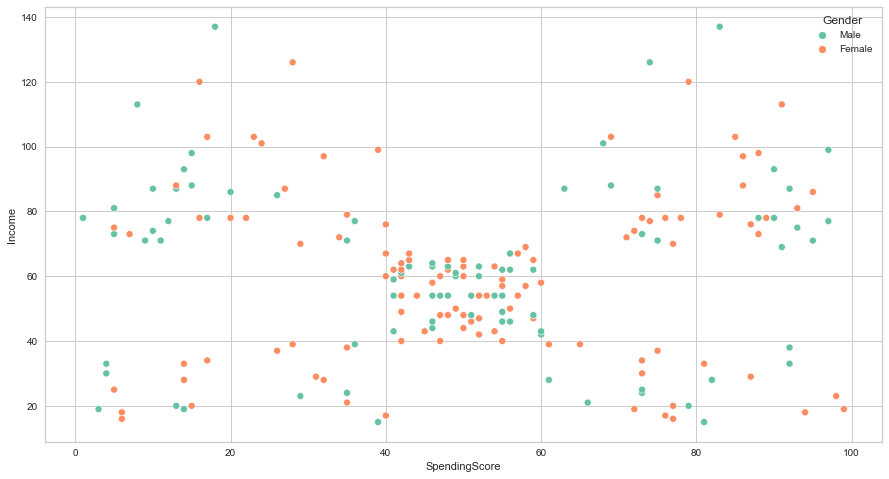

In [19]:
plt.figure(figsize=(15, 8))

sns.scatterplot(data=customer_df, x='SpendingScore', y='Income', hue='Gender');

Insights:
- five visually recognizable clusters seem to be represent customers that:
    - have high income and low spending score
    - low income and low spending score
    - high income and low spending score
    - high income and high spending score
    - dense middle cluster with middle income and middle spending score

# Clustering

We are going to try a few clustering models in the next sections but for now we need to preprocess our data set in order to proceed.

## Data Processing

Let's build a data processing pipeline and generate an input for unsupervised models:

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [27]:
data_processor = Pipeline([
    ('processing', ColumnTransformer([
            ('gender_encoder', OrdinalEncoder(), ['Gender']),
            ('spending_group_encoder', OrdinalEncoder(categories=[['low', 'medium', 'high']]), ['SpendingGroup']),
        ], remainder='passthrough')
    )
])

data_processor

Pipeline(steps=[('processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('gender_encoder',
                                                  OrdinalEncoder(),
                                                  ['Gender']),
                                                 ('spending_group_encoder',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high']]),
                                                  ['SpendingGroup'])]))])

In [46]:
X = data_processor.fit_transform(customer_df)

X

array([[  1.,   1.,  19.,  15.,  39.],
       [  1.,   2.,  21.,  15.,  81.],
       [  0.,   0.,  20.,  16.,   6.],
       [  0.,   2.,  23.,  16.,  77.],
       [  0.,   1.,  31.,  17.,  40.],
       [  0.,   2.,  22.,  17.,  76.],
       [  0.,   0.,  35.,  18.,   6.],
       [  0.,   2.,  23.,  18.,  94.],
       [  1.,   0.,  64.,  19.,   3.],
       [  0.,   2.,  30.,  19.,  72.],
       [  1.,   0.,  67.,  19.,  14.],
       [  0.,   2.,  35.,  19.,  99.],
       [  0.,   0.,  58.,  20.,  15.],
       [  0.,   2.,  24.,  20.,  77.],
       [  1.,   0.,  37.,  20.,  13.],
       [  1.,   2.,  22.,  20.,  79.],
       [  0.,   0.,  35.,  21.,  35.],
       [  1.,   2.,  20.,  21.,  66.],
       [  1.,   0.,  52.,  23.,  29.],
       [  0.,   2.,  35.,  23.,  98.],
       [  1.,   0.,  35.,  24.,  35.],
       [  1.,   2.,  25.,  24.,  73.],
       [  0.,   0.,  46.,  25.,   5.],
       [  1.,   2.,  31.,  25.,  73.],
       [  0.,   0.,  54.,  28.,  14.],
       [  1.,   2.,  29.,

## K-Mean

In [32]:
from sklearn.cluster import KMeans

kmean_model = KMeans(init='k-means++', n_init=10, random_state=RANDOM_SEED)

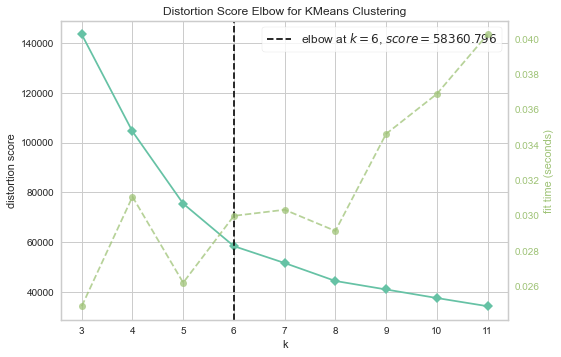

In [33]:
elbow_visualizer = KElbowVisualizer(kmean_model, k=(3, 12))

elbow_visualizer.fit(X)
elbow_visualizer.show();

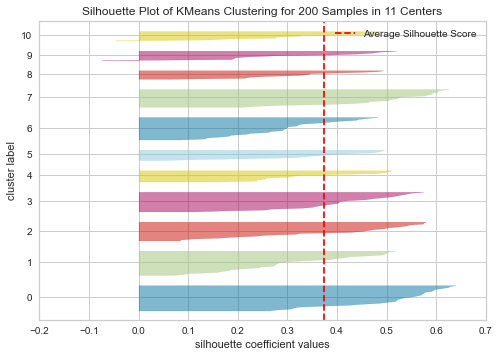

In [34]:
silhouette_visualizer = SilhouetteVisualizer(kmean_model, colors='yellowbrick')

silhouette_visualizer.fit(X);
silhouette_visualizer.show();

In [56]:
kmean_model = KMeans(n_clusters=6, init='k-means++', n_init=10, random_state=RANDOM_SEED)

kmean_model.fit(X)

kmean_clusters = kmean_model.labels_
kmean_centroids = kmean_model.cluster_centers_

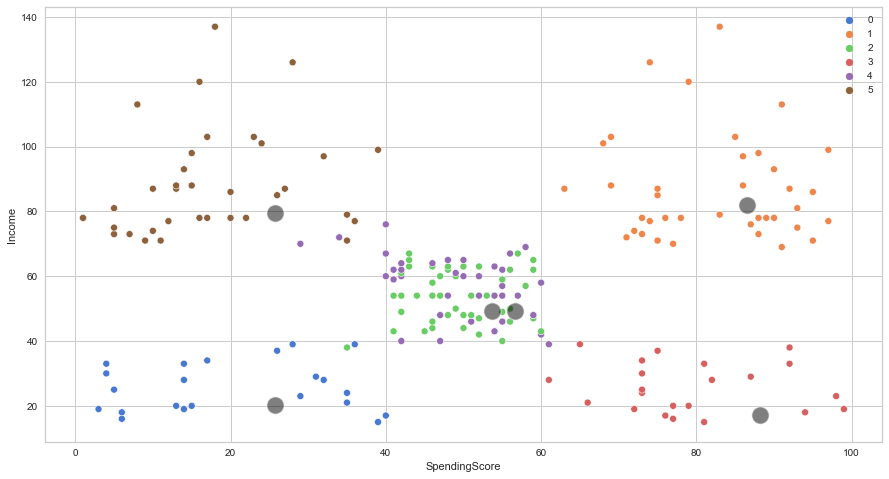

In [57]:
plt.figure(figsize=(15, 8))

sns.scatterplot(data=customer_df, x='SpendingScore', y='Income', hue=kmean_clusters, palette='muted');
sns.scatterplot(x=kmean_centroids[:, 3], y=kmean_centroids[:, 4], color='black', s=300, alpha=0.5);

In [59]:
import plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter3d(
    x=customer_df['Age'],
    y=customer_df['SpendingScore'],
    z=customer_df['Income'],
    mode='markers',
     marker=dict(
        color=kmean_clusters, 
        size= 20,
        line=dict(
            color=kmean_clusters,
            width= 12
        ),
        opacity=0.8
     )
)

data = [trace1]
layout = go.Layout(
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title='Age'),
            yaxis = dict(title='Spending Score'),
            zaxis = dict(title='Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [60]:
import plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter3d(
    x=customer_df['Gender'],
    y=customer_df['SpendingScore'],
    z=customer_df['Income'],
    mode='markers',
     marker=dict(
        color=kmean_clusters, 
        size= 20,
        line=dict(
            color=kmean_clusters,
            width= 12
        ),
        opacity=0.8
     )
)

data = [trace1]
layout = go.Layout(
    title= 'Clusters',
    scene = dict(
            xaxis=dict(title='Gender'),
            yaxis=dict(title='Spending Score'),
            zaxis=dict(title='Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## DBSCAN

# Cluster Analysis

TBU

# Summary

## References
- https://www.kaggle.com/kushal1996/customer-segmentation-k-means-analysis
- https://www.kaggle.com/fazilbtopal/popular-unsupervised-clustering-algorithms